In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import math
import os
from utils import models

In [2]:
import importlib
importlib.reload(models)

<module 'utils.models' from '/home/sandra/Documents/PHD_projects/Cycle_gan/utils/models.py'>

In [2]:
# Model / data parameters
from utils.preprocessing import prepare_dataset

ROOT_DIR = '/mnt/Archive/Data_Sets/MesoThermo'

# Directories
dir_fasta = os.path.join(ROOT_DIR,'FASTA')
dir_blast = os.path.join(ROOT_DIR,'BLAST_record')
dir_pdb = '/mnt/Archive/PDB'
outfolder = os.path.join(ROOT_DIR,'Dist_Mat/Thermophile')

name_thermo = 'dist_termo.fasta'
name_meso   = 'dist_meso.fasta'

thermo_train, thermo_val = prepare_dataset(dir_fasta, name_thermo, file_format = 'fasta', seq_length = 512, t_v_split = 0.1)
meso_train,   meso_val   = prepare_dataset(dir_fasta, name_meso  , file_format = 'fasta', seq_length = 512, t_v_split = 0.1)


In [3]:
# Create model

model_type = 'res'

p_gen = {'max_seq_len': 512,
     'num_classes': 10,
     'emb_size': 10,
     'num_filter': [32, 64, 128, 256],
     'kernel_size':[6, 4, 3, 3, 3] ,
     'sampling_stride': [2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.0, 0.0, 0.0, 0.0, 0.0],
     'use_max_pool': False,
     'output_activation': 'softmax'}
p_dec = {'max_seq_len': 512,
     'num_classes': 10,
     'emb_size': 10,
     'num_filter': [32, 64, 128, 256, 512],
     'kernel_size':[6, 4, 3, 3, 3] ,
     'sampling_stride': [2, 2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.0, 0.0, 0.0, 0.0, 0.0],
     'use_max_pool': False,
     'output_activation': 'softmax'}

#model_encode   = models.Generator(p_gen, True) 
model_encode   = models.U_net(p_gen, model_type, emb = False)
#model_decode   = models.Generator(p_gen, False)
model_decode  = models.U_net(p_gen, model_type, emb = False)
model_discrim_x  = models.Discriminator_conv(p_dec)
model_discrim_y  = models.Discriminator_conv(p_dec)

In [4]:
#cycle gan

class MyModel(tf.keras.Model):

    def __init__(self,model_encode, model_decode, model_discrim_x, model_discrim_y, lambda_cycle = 10):
        super(MyModel, self).__init__()
        self.G = model_encode
        self.F = model_decode
        self.D_x = model_discrim_x
        self.D_y = model_discrim_y
        self.lambda_cycle = lambda_cycle
        self.nois = tf.keras.layers.GaussianNoise(0.2)
        self.add  = tf.keras.layers.Add()
        


    def call(self, batch_data, training = True):
        _, X_bin, W_x = batch_data[0]
        _, Y_bin, W_y= batch_data[1]
        
        fake_y = self.G(X_bin, training=training)
        fake_x = self.F(Y_bin, training=training)
        
        # Cycle: x -> y -> x
        
        cycled_x = self.F(fake_y, training=training)
        cycled_y = self.G(fake_x, training=training)

        # Discriminator output
        #Y_bin = tf.keras.activations.softmax(self.nois(Y_bin)) 
        disc_real_y, _ = self.D_y(Y_bin, training=training)
        disc_fake_y, _ = self.D_y(fake_y, training=training)
        disc_real_x, _ = self.D_x(X_bin, training=training)
        disc_fake_x, _ = self.D_x(fake_x, training=training)
        
        return cycled_x, cycled_y, disc_real_x, disc_fake_x, disc_real_y, disc_fake_y

@tf.function
def train_step(model, batch_data, loss_fns, optimizers,lambda_cycle = 10):
    
    generator_loss_fn = loss_fns[0]
    cycle_loss_fn = loss_fns[1]
    disc_loss_fn = loss_fns[2]
    
    GF_optimizer = optimizers[0]
    D_optimizer = optimizers[1]
    
    _, X_bin, W_x= batch_data[0]
    _, Y_bin, W_y= batch_data[1]

    
    with tf.GradientTape(persistent=True) as tape:
        cycled_x, cycled_y, disc_real_x, disc_fake_x, disc_real_y, disc_fake_y = model(batch_data)

        gen_G_loss = generator_loss_fn(disc_fake_y)
        gen_F_loss = generator_loss_fn(disc_fake_x)
        
        gen_cycle_x_loss = cycle_loss_fn(X_bin, cycled_x, W_x) * lambda_cycle
        gen_cycle_y_loss = cycle_loss_fn(Y_bin, cycled_y, W_y) * lambda_cycle
        # Discriminator loss
        
        tot_loss_G = gen_G_loss + gen_cycle_x_loss
        tot_loss_F = gen_F_loss + gen_cycle_y_loss
    
        loss_D_y = disc_loss_fn(disc_real_y, disc_fake_y)
        loss_D_x = disc_loss_fn(disc_real_x, disc_fake_x)
    
    grads_G = tape.gradient(tot_loss_G, model.G.trainable_variables)
    grads_F = tape.gradient(tot_loss_F, model.F.trainable_variables)
    
    # Get the gradients for the discriminators
    grads_disc_y = tape.gradient(loss_D_y, model.D_y.trainable_variables)
    grads_disc_x = tape.gradient(loss_D_x, model.D_x.trainable_variables)
    
    # Update the weights of the generators 
    GF_optimizer.apply_gradients(zip(grads_G, model.G.trainable_variables))  
    GF_optimizer.apply_gradients(zip(grads_F, model.F.trainable_variables))

    # Update the weights of the discriminators
    D_optimizer.apply_gradients(zip(grads_disc_y, model.D_y.trainable_variables))
    D_optimizer.apply_gradients(zip(grads_disc_x, model.D_x.trainable_variables))

    return {
        "Gen_G_loss": gen_G_loss,
        "Cycle_X_loss": gen_cycle_x_loss,
        "Disc_X_loss": loss_D_x,
        "Gen_F_loss": gen_F_loss,
        "Cycle_Y_loss": gen_cycle_y_loss,
        "Disc_Y_loss": loss_D_y
    }




In [6]:
# Loss functions
cross = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0.0,
    reduction = tf.keras.losses.Reduction.NONE,
    name='categorical_crossentropy')

def cycle_loss_fn(real, cycled, w):
    return cross(real, cycled, w)
# Define the loss function for the generators
def generator_loss_fn(fake):
    #return -tf.reduce_mean(fake)
    return tf.keras.backend.softplus(fake)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = tf.keras.backend.softplus(fake)
    fake_loss = tf.keras.backend.softplus(-real)
    #real_loss = tf.reduce_mean(real)
    #fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss


In [ ]:
0.01 * tf.reduce_mean(tf.square(discriminator_real))
            d_loss_fake = discriminator_fake + 0.01 * tf.reduce_mean(tf.square(discriminator_fake))

In [5]:
cross = tf.keras.losses.CategoricalCrossentropy()
cross_bin = tf.keras.losses.BinaryCrossentropy()
def cycle_loss_fn(real, cycled, w):
    return cross(real, cycled, w)
# Define the loss function for the generators
def generator_loss_fn(fake):
    #return -tf.reduce_mean(fake)
    
    return cross_bin(tf.ones_like(fake), fake)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = cross_bin(tf.ones_like(real), real)
    fake_loss = cross_bin(tf.zeros_like(fake), fake)
    #real_loss = tf.reduce_mean(real)
    #fake_loss = tf.reduce_mean(fake)
    return fake_loss + real_loss

In [6]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        if epoch % 10 == 0:
            for i, img in enumerate(train_f0[:4]):
                prediction = cycle_gan_model.enc(img.reshape(1,28,28,1)).numpy()
                prediction = (prediction * 255).astype(np.uint8).reshape(28,28)
                img = (img *255).astype(np.uint8).reshape(28,28)

                ax[i, 0].imshow(img)
                ax[i, 1].imshow(prediction)
                ax[i, 0].set_title("Input image")
                ax[i, 1].set_title("Translated image")
                ax[i, 0].axis("off")
                ax[i, 1].axis("off")

            plt.show()
            plt.close()

In [7]:
# Training

# Create cycle gan model
cycle_gan_model = MyModel(model_encode,model_decode, model_discrim_x, model_discrim_y, lambda_cycle=10)

# Callbacks

checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)



train_loss_G = tf.keras.metrics.Mean('loss_G', dtype=tf.float32)
train_loss_cycle_x = tf.keras.metrics.Mean('loss_cycle_x', dtype=tf.float32)
train_loss_disc_y = tf.keras.metrics.Mean('loss_disc_y', dtype=tf.float32)
train_loss_F = tf.keras.metrics.Mean('loss_F', dtype=tf.float32)
train_loss_cycle_y = tf.keras.metrics.Mean('loss_cycle_y', dtype=tf.float32)
train_loss_disc_x = tf.keras.metrics.Mean('loss_disc_x', dtype=tf.float32)

# Optimizers
GF_opt=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
D_opt=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

# Training
for i in range(2000):
    batches_x = meso_train.shuffle(buffer_size = 40000).batch(64, drop_remainder=True) 
    batches_y = thermo_train.shuffle(buffer_size = 40000).batch(64, drop_remainder=True)
    for step, x in enumerate(zip(batches_x,batches_y)):
    
        losses = train_step(model = cycle_gan_model, batch_data =x,
                            loss_fns = (generator_loss_fn, cycle_loss_fn, discriminator_loss_fn),
                            optimizers = [GF_opt, D_opt],
                           lambda_cycle = 1)

        train_loss_G(losses["Gen_G_loss"]) 
        train_loss_cycle_x(losses["Cycle_X_loss"])
        train_loss_disc_y(losses["Disc_X_loss"])
        train_loss_F(losses["Gen_F_loss"]) 
        train_loss_cycle_y(losses["Cycle_Y_loss"])
        train_loss_disc_x(losses["Disc_Y_loss"])
        
        
    print("Epoch: %d Loss_G: %2.4f Loss_F: %2.4f Loss_cycle_X: %2.4f Loss_cycle_Y: %2.4f Loss_D_Y: %2.4f Loss_D_X %2.4f" % 
          (i, float(train_loss_G.result()), float(train_loss_F.result()), float(train_loss_cycle_x.result()), float(train_loss_cycle_y.result()), float(train_loss_disc_y.result()), float(train_loss_disc_x.result())))
    train_loss_G.reset_states()
    train_loss_cycle_x.reset_states()
    train_loss_disc_y.reset_states()
    train_loss_F.reset_states() 
    train_loss_cycle_y.reset_states()
    train_loss_disc_x.reset_states()

Epoch: 0 Loss_G: 0.7850 Loss_F: 0.8204 Loss_cycle_X: 1.6967 Loss_cycle_Y: 1.9709 Loss_D_Y: 1.2936 Loss_D_X 1.2775
Epoch: 1 Loss_G: 0.9899 Loss_F: 1.0564 Loss_cycle_X: 1.6425 Loss_cycle_Y: 1.8502 Loss_D_Y: 0.9340 Loss_D_X 0.9800
Epoch: 2 Loss_G: 1.2419 Loss_F: 1.2980 Loss_cycle_X: 1.6422 Loss_cycle_Y: 1.8506 Loss_D_Y: 0.6878 Loss_D_X 0.7318
Epoch: 3 Loss_G: 1.4653 Loss_F: 1.5114 Loss_cycle_X: 1.6462 Loss_cycle_Y: 1.8555 Loss_D_Y: 0.5317 Loss_D_X 0.5705
Epoch: 4 Loss_G: 1.7142 Loss_F: 1.7290 Loss_cycle_X: 1.6510 Loss_cycle_Y: 1.8337 Loss_D_Y: 0.4154 Loss_D_X 0.4146
Epoch: 5 Loss_G: 1.8917 Loss_F: 1.9655 Loss_cycle_X: 1.6343 Loss_cycle_Y: 1.8577 Loss_D_Y: 0.3189 Loss_D_X 0.3302
Epoch: 6 Loss_G: 2.0621 Loss_F: 1.9879 Loss_cycle_X: 1.6208 Loss_cycle_Y: 1.8413 Loss_D_Y: 0.2921 Loss_D_X 0.2785
Epoch: 7 Loss_G: 2.2958 Loss_F: 2.1225 Loss_cycle_X: 1.6144 Loss_cycle_Y: 1.8293 Loss_D_Y: 0.2560 Loss_D_X 0.2199
Epoch: 8 Loss_G: 2.5109 Loss_F: 2.3704 Loss_cycle_X: 1.6205 Loss_cycle_Y: 1.8251 Loss_D_

Epoch: 81 Loss_G: 6.7800 Loss_F: 6.3385 Loss_cycle_X: 1.5742 Loss_cycle_Y: 1.7933 Loss_D_Y: 0.0041 Loss_D_X 0.0025
Epoch: 82 Loss_G: 6.8010 Loss_F: 6.3275 Loss_cycle_X: 1.5712 Loss_cycle_Y: 1.8021 Loss_D_Y: 0.0042 Loss_D_X 0.0025
Epoch: 83 Loss_G: 6.8922 Loss_F: 6.4719 Loss_cycle_X: 1.5709 Loss_cycle_Y: 1.8042 Loss_D_Y: 0.0037 Loss_D_X 0.0023
Epoch: 84 Loss_G: 6.8706 Loss_F: 6.4145 Loss_cycle_X: 1.5680 Loss_cycle_Y: 1.7970 Loss_D_Y: 0.0038 Loss_D_X 0.0023
Epoch: 85 Loss_G: 6.9664 Loss_F: 6.4361 Loss_cycle_X: 1.5707 Loss_cycle_Y: 1.8033 Loss_D_Y: 0.0037 Loss_D_X 0.0022
Epoch: 86 Loss_G: 7.0069 Loss_F: 6.5164 Loss_cycle_X: 1.5763 Loss_cycle_Y: 1.8019 Loss_D_Y: 0.0035 Loss_D_X 0.0021
Epoch: 87 Loss_G: 7.1587 Loss_F: 6.5142 Loss_cycle_X: 1.5896 Loss_cycle_Y: 1.7916 Loss_D_Y: 0.0035 Loss_D_X 0.0019
Epoch: 88 Loss_G: 7.0659 Loss_F: 7.0117 Loss_cycle_X: 1.5754 Loss_cycle_Y: 1.7899 Loss_D_Y: 0.0026 Loss_D_X 0.0022
Epoch: 89 Loss_G: 6.8626 Loss_F: 6.8972 Loss_cycle_X: 1.5933 Loss_cycle_Y: 1.768

Epoch: 152 Loss_G: 7.0511 Loss_F: 8.7975 Loss_cycle_X: 1.5467 Loss_cycle_Y: 1.7655 Loss_D_Y: 0.0003 Loss_D_X 0.0036
Epoch: 153 Loss_G: 7.2248 Loss_F: 8.9072 Loss_cycle_X: 1.5466 Loss_cycle_Y: 1.7607 Loss_D_Y: 0.0004 Loss_D_X 0.0032
Epoch: 154 Loss_G: 7.1023 Loss_F: 9.0285 Loss_cycle_X: 1.5411 Loss_cycle_Y: 1.7506 Loss_D_Y: 0.0003 Loss_D_X 0.0030
Epoch: 155 Loss_G: 7.1805 Loss_F: 7.8303 Loss_cycle_X: 1.5455 Loss_cycle_Y: 1.7553 Loss_D_Y: 0.0040 Loss_D_X 0.0028
Epoch: 156 Loss_G: 7.1560 Loss_F: 7.3851 Loss_cycle_X: 1.5433 Loss_cycle_Y: 1.7528 Loss_D_Y: 0.0012 Loss_D_X 0.0029
Epoch: 157 Loss_G: 7.2929 Loss_F: 7.5395 Loss_cycle_X: 1.5405 Loss_cycle_Y: 1.7537 Loss_D_Y: 0.0010 Loss_D_X 0.0024
Epoch: 158 Loss_G: 7.0675 Loss_F: 7.8216 Loss_cycle_X: 1.5573 Loss_cycle_Y: 1.7587 Loss_D_Y: 0.0008 Loss_D_X 0.0053
Epoch: 159 Loss_G: 6.4499 Loss_F: 7.9233 Loss_cycle_X: 1.5825 Loss_cycle_Y: 1.7521 Loss_D_Y: 0.0008 Loss_D_X 0.0058
Epoch: 160 Loss_G: 6.5396 Loss_F: 7.9790 Loss_cycle_X: 1.5359 Loss_cycle

Epoch: 223 Loss_G: 8.4811 Loss_F: 9.9126 Loss_cycle_X: 1.5771 Loss_cycle_Y: 1.7824 Loss_D_Y: 0.0001 Loss_D_X 0.0005
Epoch: 224 Loss_G: 8.5767 Loss_F: 9.9810 Loss_cycle_X: 1.5793 Loss_cycle_Y: 1.7869 Loss_D_Y: 0.0001 Loss_D_X 0.0005
Epoch: 225 Loss_G: 8.8171 Loss_F: 10.0681 Loss_cycle_X: 1.5724 Loss_cycle_Y: 1.7826 Loss_D_Y: 0.0001 Loss_D_X 0.0006
Epoch: 226 Loss_G: 5.9742 Loss_F: 10.2328 Loss_cycle_X: 1.5805 Loss_cycle_Y: 1.7814 Loss_D_Y: 0.0001 Loss_D_X 0.1103
Epoch: 227 Loss_G: 5.8902 Loss_F: 10.1712 Loss_cycle_X: 1.5878 Loss_cycle_Y: 1.7887 Loss_D_Y: 0.0001 Loss_D_X 0.0113
Epoch: 228 Loss_G: 5.5565 Loss_F: 10.5682 Loss_cycle_X: 1.6144 Loss_cycle_Y: 1.7940 Loss_D_Y: 0.0001 Loss_D_X 0.0686
Epoch: 229 Loss_G: 5.6900 Loss_F: 10.6686 Loss_cycle_X: 1.6166 Loss_cycle_Y: 1.7904 Loss_D_Y: 0.0001 Loss_D_X 0.0107
Epoch: 230 Loss_G: 5.6288 Loss_F: 10.7564 Loss_cycle_X: 1.6092 Loss_cycle_Y: 1.7951 Loss_D_Y: 0.0001 Loss_D_X 0.0108
Epoch: 231 Loss_G: 5.8886 Loss_F: 10.7375 Loss_cycle_X: 1.6094 Los

Epoch: 294 Loss_G: 8.6453 Loss_F: 11.9855 Loss_cycle_X: 1.5827 Loss_cycle_Y: 1.8348 Loss_D_Y: 0.0000 Loss_D_X 0.0007
Epoch: 295 Loss_G: 8.6868 Loss_F: 11.9097 Loss_cycle_X: 1.5823 Loss_cycle_Y: 1.8417 Loss_D_Y: 0.0000 Loss_D_X 0.0007
Epoch: 296 Loss_G: 8.8614 Loss_F: 12.1771 Loss_cycle_X: 1.5894 Loss_cycle_Y: 1.8382 Loss_D_Y: 0.0000 Loss_D_X 0.0006
Epoch: 297 Loss_G: 8.6673 Loss_F: 12.1651 Loss_cycle_X: 1.5865 Loss_cycle_Y: 1.8310 Loss_D_Y: 0.0000 Loss_D_X 0.0007
Epoch: 298 Loss_G: 8.6776 Loss_F: 12.0583 Loss_cycle_X: 1.5970 Loss_cycle_Y: 1.8311 Loss_D_Y: 0.0000 Loss_D_X 0.0007
Epoch: 299 Loss_G: 8.8572 Loss_F: 12.1167 Loss_cycle_X: 1.6030 Loss_cycle_Y: 1.8384 Loss_D_Y: 0.0000 Loss_D_X 0.0007
Epoch: 300 Loss_G: 8.9407 Loss_F: 12.0082 Loss_cycle_X: 1.5947 Loss_cycle_Y: 1.8376 Loss_D_Y: 0.0000 Loss_D_X 0.0006
Epoch: 301 Loss_G: 8.8071 Loss_F: 12.1441 Loss_cycle_X: 1.5930 Loss_cycle_Y: 1.8386 Loss_D_Y: 0.0000 Loss_D_X 0.0006
Epoch: 302 Loss_G: 8.8772 Loss_F: 12.2801 Loss_cycle_X: 1.5895 L

Epoch: 364 Loss_G: 10.5420 Loss_F: 10.2790 Loss_cycle_X: 1.6990 Loss_cycle_Y: 1.9276 Loss_D_Y: 0.0076 Loss_D_X 0.0001
Epoch: 365 Loss_G: 10.5295 Loss_F: 9.8991 Loss_cycle_X: 1.6876 Loss_cycle_Y: 1.9337 Loss_D_Y: 0.0004 Loss_D_X 0.0001
Epoch: 366 Loss_G: 10.5814 Loss_F: 9.5778 Loss_cycle_X: 1.6813 Loss_cycle_Y: 1.9352 Loss_D_Y: 0.0004 Loss_D_X 0.0001
Epoch: 367 Loss_G: 10.5634 Loss_F: 9.6956 Loss_cycle_X: 1.6857 Loss_cycle_Y: 1.9200 Loss_D_Y: 0.0003 Loss_D_X 0.0001
Epoch: 368 Loss_G: 10.5586 Loss_F: 9.6863 Loss_cycle_X: 1.6816 Loss_cycle_Y: 1.9139 Loss_D_Y: 0.0003 Loss_D_X 0.0001
Epoch: 369 Loss_G: 10.6326 Loss_F: 9.6829 Loss_cycle_X: 1.6739 Loss_cycle_Y: 1.9121 Loss_D_Y: 0.0003 Loss_D_X 0.0001
Epoch: 370 Loss_G: 10.6805 Loss_F: 9.2531 Loss_cycle_X: 1.6690 Loss_cycle_Y: 1.9102 Loss_D_Y: 0.0004 Loss_D_X 0.0001
Epoch: 371 Loss_G: 10.7833 Loss_F: 8.9952 Loss_cycle_X: 1.6688 Loss_cycle_Y: 1.9029 Loss_D_Y: 0.0004 Loss_D_X 0.0001
Epoch: 372 Loss_G: 10.8693 Loss_F: 9.0375 Loss_cycle_X: 1.6576 

Epoch: 434 Loss_G: 12.5275 Loss_F: 10.0946 Loss_cycle_X: 1.6153 Loss_cycle_Y: 1.8971 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 435 Loss_G: 12.5228 Loss_F: 10.0010 Loss_cycle_X: 1.6246 Loss_cycle_Y: 1.8993 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 436 Loss_G: 12.5317 Loss_F: 9.9465 Loss_cycle_X: 1.6156 Loss_cycle_Y: 1.8915 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 437 Loss_G: 12.6253 Loss_F: 10.0169 Loss_cycle_X: 1.6074 Loss_cycle_Y: 1.8882 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 438 Loss_G: 12.5382 Loss_F: 10.0824 Loss_cycle_X: 1.6103 Loss_cycle_Y: 1.8858 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 439 Loss_G: 12.4880 Loss_F: 10.0926 Loss_cycle_X: 1.6095 Loss_cycle_Y: 1.8821 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 440 Loss_G: 12.5971 Loss_F: 10.1773 Loss_cycle_X: 1.6078 Loss_cycle_Y: 1.8787 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 441 Loss_G: 12.6555 Loss_F: 10.2647 Loss_cycle_X: 1.6125 Loss_cycle_Y: 1.8730 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 442 Loss_G: 12.7467 Loss_F: 10.2953 Loss_cycle_X: 

Epoch: 504 Loss_G: 7.2454 Loss_F: 7.8021 Loss_cycle_X: 1.5883 Loss_cycle_Y: 1.9268 Loss_D_Y: 0.0015 Loss_D_X 0.0029
Epoch: 505 Loss_G: 7.7120 Loss_F: 7.5019 Loss_cycle_X: 1.5825 Loss_cycle_Y: 1.9384 Loss_D_Y: 0.0018 Loss_D_X 0.0028
Epoch: 506 Loss_G: 8.4741 Loss_F: 8.3236 Loss_cycle_X: 1.5810 Loss_cycle_Y: 1.9493 Loss_D_Y: 0.0013 Loss_D_X 0.0062
Epoch: 507 Loss_G: 9.4355 Loss_F: 8.1393 Loss_cycle_X: 1.5644 Loss_cycle_Y: 1.9653 Loss_D_Y: 0.0011 Loss_D_X 0.0463
Epoch: 508 Loss_G: 10.2700 Loss_F: 7.9461 Loss_cycle_X: 1.5489 Loss_cycle_Y: 1.9705 Loss_D_Y: 0.0011 Loss_D_X 0.0010
Epoch: 509 Loss_G: 9.6146 Loss_F: 7.8300 Loss_cycle_X: 1.5587 Loss_cycle_Y: 1.9635 Loss_D_Y: 0.0012 Loss_D_X 0.0011
Epoch: 510 Loss_G: 8.7007 Loss_F: 7.9203 Loss_cycle_X: 1.5536 Loss_cycle_Y: 1.9457 Loss_D_Y: 0.0011 Loss_D_X 0.0015
Epoch: 511 Loss_G: 8.2078 Loss_F: 8.2069 Loss_cycle_X: 1.5629 Loss_cycle_Y: 1.9374 Loss_D_Y: 0.0009 Loss_D_X 0.0015
Epoch: 512 Loss_G: 8.2949 Loss_F: 8.1753 Loss_cycle_X: 1.5677 Loss_cycl

Epoch: 575 Loss_G: 11.1535 Loss_F: 10.5201 Loss_cycle_X: 1.5926 Loss_cycle_Y: 1.9606 Loss_D_Y: 0.0002 Loss_D_X 0.0002
Epoch: 576 Loss_G: 11.5833 Loss_F: 11.2260 Loss_cycle_X: 1.5924 Loss_cycle_Y: 1.9687 Loss_D_Y: 0.0002 Loss_D_X 0.0001
Epoch: 577 Loss_G: 13.1047 Loss_F: 9.6205 Loss_cycle_X: 1.5909 Loss_cycle_Y: 1.9675 Loss_D_Y: 0.0003 Loss_D_X 0.0001
Epoch: 578 Loss_G: 12.4388 Loss_F: 10.4752 Loss_cycle_X: 1.5949 Loss_cycle_Y: 1.9669 Loss_D_Y: 0.0002 Loss_D_X 0.0001
Epoch: 579 Loss_G: 12.0997 Loss_F: 10.1574 Loss_cycle_X: 1.5957 Loss_cycle_Y: 1.9694 Loss_D_Y: 0.0002 Loss_D_X 0.0001
Epoch: 580 Loss_G: 11.6884 Loss_F: 10.6077 Loss_cycle_X: 1.5918 Loss_cycle_Y: 1.9700 Loss_D_Y: 0.0002 Loss_D_X 0.0001
Epoch: 581 Loss_G: 11.3390 Loss_F: 10.4850 Loss_cycle_X: 1.5830 Loss_cycle_Y: 1.9706 Loss_D_Y: 0.0002 Loss_D_X 0.0001
Epoch: 582 Loss_G: 11.5332 Loss_F: 11.4031 Loss_cycle_X: 1.5911 Loss_cycle_Y: 1.9632 Loss_D_Y: 0.0001 Loss_D_X 0.0001
Epoch: 583 Loss_G: 11.5842 Loss_F: 10.9075 Loss_cycle_X: 

Epoch: 645 Loss_G: 12.8424 Loss_F: 11.8093 Loss_cycle_X: 1.5768 Loss_cycle_Y: 1.9332 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 646 Loss_G: 12.8578 Loss_F: 11.8286 Loss_cycle_X: 1.5723 Loss_cycle_Y: 1.9335 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 647 Loss_G: 12.5433 Loss_F: 12.2436 Loss_cycle_X: 1.5746 Loss_cycle_Y: 1.9297 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 648 Loss_G: 12.5923 Loss_F: 12.7559 Loss_cycle_X: 1.5768 Loss_cycle_Y: 1.9349 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 649 Loss_G: 12.4598 Loss_F: 12.3288 Loss_cycle_X: 1.5724 Loss_cycle_Y: 1.9326 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 650 Loss_G: 12.0455 Loss_F: 11.7210 Loss_cycle_X: 1.5749 Loss_cycle_Y: 1.9339 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 651 Loss_G: 12.9497 Loss_F: 12.0569 Loss_cycle_X: 1.5793 Loss_cycle_Y: 1.9326 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 652 Loss_G: 12.6637 Loss_F: 11.9936 Loss_cycle_X: 1.5787 Loss_cycle_Y: 1.9216 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 653 Loss_G: 12.5434 Loss_F: 11.5203 Loss_cycle_X:

Epoch: 715 Loss_G: 15.0107 Loss_F: 12.7981 Loss_cycle_X: 1.6195 Loss_cycle_Y: 1.8939 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 716 Loss_G: 14.5462 Loss_F: 12.8209 Loss_cycle_X: 1.6036 Loss_cycle_Y: 1.8977 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 717 Loss_G: 14.0979 Loss_F: 12.9533 Loss_cycle_X: 1.6029 Loss_cycle_Y: 1.8958 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 718 Loss_G: 14.2571 Loss_F: 12.9906 Loss_cycle_X: 1.6006 Loss_cycle_Y: 1.9004 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 719 Loss_G: 14.1458 Loss_F: 13.0678 Loss_cycle_X: 1.5960 Loss_cycle_Y: 1.8976 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 720 Loss_G: 14.7569 Loss_F: 13.0769 Loss_cycle_X: 1.5999 Loss_cycle_Y: 1.9007 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 721 Loss_G: 15.2883 Loss_F: 13.1020 Loss_cycle_X: 1.6000 Loss_cycle_Y: 1.8959 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 722 Loss_G: 14.1828 Loss_F: 13.1678 Loss_cycle_X: 1.5920 Loss_cycle_Y: 1.9007 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 723 Loss_G: 14.5108 Loss_F: 13.2360 Loss_cycle_X:

Epoch: 785 Loss_G: 14.9818 Loss_F: 11.7834 Loss_cycle_X: 1.5773 Loss_cycle_Y: 1.9137 Loss_D_Y: 0.0003 Loss_D_X 0.0000
Epoch: 786 Loss_G: 14.9523 Loss_F: 10.2116 Loss_cycle_X: 1.5793 Loss_cycle_Y: 1.8947 Loss_D_Y: 0.0006 Loss_D_X 0.0000
Epoch: 787 Loss_G: 14.9777 Loss_F: 10.6629 Loss_cycle_X: 1.5796 Loss_cycle_Y: 1.8885 Loss_D_Y: 0.0004 Loss_D_X 0.0000
Epoch: 788 Loss_G: 15.0167 Loss_F: 10.9612 Loss_cycle_X: 1.5838 Loss_cycle_Y: 1.8833 Loss_D_Y: 0.0004 Loss_D_X 0.0000
Epoch: 789 Loss_G: 15.0239 Loss_F: 10.8062 Loss_cycle_X: 1.5756 Loss_cycle_Y: 1.8846 Loss_D_Y: 0.0003 Loss_D_X 0.0000
Epoch: 790 Loss_G: 15.0592 Loss_F: 10.7892 Loss_cycle_X: 1.5791 Loss_cycle_Y: 1.8831 Loss_D_Y: 0.0003 Loss_D_X 0.0000
Epoch: 791 Loss_G: 14.9904 Loss_F: 10.7953 Loss_cycle_X: 1.5783 Loss_cycle_Y: 1.8789 Loss_D_Y: 0.0002 Loss_D_X 0.0000
Epoch: 792 Loss_G: 15.1155 Loss_F: 10.7725 Loss_cycle_X: 1.5745 Loss_cycle_Y: 1.8758 Loss_D_Y: 0.0002 Loss_D_X 0.0000
Epoch: 793 Loss_G: 14.6996 Loss_F: 10.6590 Loss_cycle_X:

Epoch: 855 Loss_G: 15.9711 Loss_F: 12.0521 Loss_cycle_X: 1.5637 Loss_cycle_Y: 1.8946 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 856 Loss_G: 15.8589 Loss_F: 11.5723 Loss_cycle_X: 1.5715 Loss_cycle_Y: 1.8970 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 857 Loss_G: 15.6906 Loss_F: 11.9015 Loss_cycle_X: 1.5748 Loss_cycle_Y: 1.9039 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 858 Loss_G: 15.7186 Loss_F: 12.1243 Loss_cycle_X: 1.5724 Loss_cycle_Y: 1.8991 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 859 Loss_G: 15.9144 Loss_F: 12.2016 Loss_cycle_X: 1.5676 Loss_cycle_Y: 1.9002 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 860 Loss_G: 16.0427 Loss_F: 12.2430 Loss_cycle_X: 1.5625 Loss_cycle_Y: 1.8941 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 861 Loss_G: 16.0730 Loss_F: 12.4420 Loss_cycle_X: 1.5655 Loss_cycle_Y: 1.8925 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 862 Loss_G: 16.0704 Loss_F: 12.3695 Loss_cycle_X: 1.5585 Loss_cycle_Y: 1.8916 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 863 Loss_G: 16.2392 Loss_F: 12.4746 Loss_cycle_X:

Epoch: 925 Loss_G: 17.7669 Loss_F: 10.3152 Loss_cycle_X: 1.5895 Loss_cycle_Y: 1.8741 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 926 Loss_G: 17.5902 Loss_F: 10.3381 Loss_cycle_X: 1.5863 Loss_cycle_Y: 1.8698 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 927 Loss_G: 17.1771 Loss_F: 11.6526 Loss_cycle_X: 1.5847 Loss_cycle_Y: 1.8710 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 928 Loss_G: 17.2333 Loss_F: 10.8968 Loss_cycle_X: 1.5958 Loss_cycle_Y: 1.8681 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 929 Loss_G: 17.2756 Loss_F: 10.8829 Loss_cycle_X: 1.5920 Loss_cycle_Y: 1.8647 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 930 Loss_G: 17.7329 Loss_F: 10.8884 Loss_cycle_X: 1.5862 Loss_cycle_Y: 1.8597 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 931 Loss_G: 17.6613 Loss_F: 11.4020 Loss_cycle_X: 1.5886 Loss_cycle_Y: 1.8584 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 932 Loss_G: 17.8180 Loss_F: 11.5138 Loss_cycle_X: 1.5866 Loss_cycle_Y: 1.8613 Loss_D_Y: 0.0001 Loss_D_X 0.0000
Epoch: 933 Loss_G: 17.8805 Loss_F: 11.8190 Loss_cycle_X:

Epoch: 995 Loss_G: 10.4469 Loss_F: 12.1967 Loss_cycle_X: 1.6537 Loss_cycle_Y: 1.9389 Loss_D_Y: 0.0000 Loss_D_X 0.0006
Epoch: 996 Loss_G: 10.4970 Loss_F: 12.3871 Loss_cycle_X: 1.6531 Loss_cycle_Y: 1.9382 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 997 Loss_G: 10.7608 Loss_F: 12.1978 Loss_cycle_X: 1.6452 Loss_cycle_Y: 1.9370 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 998 Loss_G: 10.7892 Loss_F: 12.2298 Loss_cycle_X: 1.6469 Loss_cycle_Y: 1.9399 Loss_D_Y: 0.0000 Loss_D_X 0.0013
Epoch: 999 Loss_G: 11.7322 Loss_F: 12.2648 Loss_cycle_X: 1.6412 Loss_cycle_Y: 1.9418 Loss_D_Y: 0.0000 Loss_D_X 0.0012
Epoch: 1000 Loss_G: 10.4927 Loss_F: 12.4090 Loss_cycle_X: 1.6496 Loss_cycle_Y: 1.9375 Loss_D_Y: 0.0000 Loss_D_X 0.0009
Epoch: 1001 Loss_G: 11.6131 Loss_F: 12.3633 Loss_cycle_X: 1.6547 Loss_cycle_Y: 1.9440 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 1002 Loss_G: 10.9923 Loss_F: 12.4015 Loss_cycle_X: 1.6526 Loss_cycle_Y: 1.9451 Loss_D_Y: 0.0000 Loss_D_X 0.0004
Epoch: 1003 Loss_G: 10.6773 Loss_F: 12.3169 Loss_cycl

Epoch: 1064 Loss_G: 12.5331 Loss_F: 13.7545 Loss_cycle_X: 1.6299 Loss_cycle_Y: 1.9232 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1065 Loss_G: 12.3950 Loss_F: 14.2799 Loss_cycle_X: 1.6435 Loss_cycle_Y: 1.9202 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1066 Loss_G: 12.6053 Loss_F: 13.6710 Loss_cycle_X: 1.6367 Loss_cycle_Y: 1.9230 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1067 Loss_G: 12.5936 Loss_F: 13.5463 Loss_cycle_X: 1.6392 Loss_cycle_Y: 1.9270 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1068 Loss_G: 12.6210 Loss_F: 13.5945 Loss_cycle_X: 1.6406 Loss_cycle_Y: 1.9245 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1069 Loss_G: 12.5902 Loss_F: 13.8746 Loss_cycle_X: 1.6318 Loss_cycle_Y: 1.9258 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1070 Loss_G: 12.6624 Loss_F: 14.1722 Loss_cycle_X: 1.6430 Loss_cycle_Y: 1.9297 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1071 Loss_G: 12.7820 Loss_F: 13.6767 Loss_cycle_X: 1.6388 Loss_cycle_Y: 1.9305 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1072 Loss_G: 12.7225 Loss_F: 13.6543 Loss

Epoch: 1133 Loss_G: 10.4522 Loss_F: 15.5625 Loss_cycle_X: 1.6057 Loss_cycle_Y: 1.9498 Loss_D_Y: 0.0000 Loss_D_X 0.0002
Epoch: 1134 Loss_G: 10.4952 Loss_F: 15.3077 Loss_cycle_X: 1.5967 Loss_cycle_Y: 1.9671 Loss_D_Y: 0.0000 Loss_D_X 0.0002
Epoch: 1135 Loss_G: 10.5158 Loss_F: 15.2718 Loss_cycle_X: 1.5988 Loss_cycle_Y: 1.9619 Loss_D_Y: 0.0000 Loss_D_X 0.0002
Epoch: 1136 Loss_G: 10.2411 Loss_F: 15.6817 Loss_cycle_X: 1.6012 Loss_cycle_Y: 1.9705 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 1137 Loss_G: 10.4427 Loss_F: 15.6172 Loss_cycle_X: 1.5929 Loss_cycle_Y: 1.9830 Loss_D_Y: 0.0000 Loss_D_X 0.0002
Epoch: 1138 Loss_G: 10.7770 Loss_F: 15.6165 Loss_cycle_X: 1.5998 Loss_cycle_Y: 1.9810 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1139 Loss_G: 11.0425 Loss_F: 15.5929 Loss_cycle_X: 1.5940 Loss_cycle_Y: 1.9828 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1140 Loss_G: 10.8407 Loss_F: 15.6827 Loss_cycle_X: 1.5912 Loss_cycle_Y: 1.9751 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1141 Loss_G: 10.8912 Loss_F: 15.7273 Loss

Epoch: 1202 Loss_G: 13.3424 Loss_F: 16.9253 Loss_cycle_X: 1.5936 Loss_cycle_Y: 1.9326 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1203 Loss_G: 13.1782 Loss_F: 16.7681 Loss_cycle_X: 1.5899 Loss_cycle_Y: 1.9345 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1204 Loss_G: 13.1144 Loss_F: 16.8121 Loss_cycle_X: 1.5847 Loss_cycle_Y: 1.9409 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1205 Loss_G: 13.2061 Loss_F: 16.9042 Loss_cycle_X: 1.5962 Loss_cycle_Y: 1.9351 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1206 Loss_G: 13.5447 Loss_F: 16.7087 Loss_cycle_X: 1.5966 Loss_cycle_Y: 1.9363 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1207 Loss_G: 13.2767 Loss_F: 16.5743 Loss_cycle_X: 1.5902 Loss_cycle_Y: 1.9360 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1208 Loss_G: 13.3012 Loss_F: 16.5941 Loss_cycle_X: 1.5869 Loss_cycle_Y: 1.9411 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1209 Loss_G: 13.1133 Loss_F: 16.5749 Loss_cycle_X: 1.5859 Loss_cycle_Y: 1.9411 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1210 Loss_G: 13.6463 Loss_F: 16.8132 Loss

Epoch: 1271 Loss_G: 14.9743 Loss_F: 18.3593 Loss_cycle_X: 1.6373 Loss_cycle_Y: 1.9495 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1272 Loss_G: 14.9405 Loss_F: 18.3319 Loss_cycle_X: 1.6290 Loss_cycle_Y: 1.9509 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1273 Loss_G: 15.0873 Loss_F: 18.4873 Loss_cycle_X: 1.6155 Loss_cycle_Y: 1.9541 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1274 Loss_G: 15.0727 Loss_F: 18.3033 Loss_cycle_X: 1.6207 Loss_cycle_Y: 1.9559 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1275 Loss_G: 15.1167 Loss_F: 18.3807 Loss_cycle_X: 1.6154 Loss_cycle_Y: 1.9567 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1276 Loss_G: 15.4303 Loss_F: 18.0561 Loss_cycle_X: 1.6239 Loss_cycle_Y: 1.9759 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1277 Loss_G: 15.3141 Loss_F: 18.2243 Loss_cycle_X: 1.6217 Loss_cycle_Y: 1.9627 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1278 Loss_G: 15.2939 Loss_F: 18.3199 Loss_cycle_X: 1.6140 Loss_cycle_Y: 1.9704 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1279 Loss_G: 15.1599 Loss_F: 18.2635 Loss

Epoch: 1340 Loss_G: 16.5008 Loss_F: 19.3068 Loss_cycle_X: 1.6203 Loss_cycle_Y: 1.9039 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1341 Loss_G: 16.5394 Loss_F: 19.2595 Loss_cycle_X: 1.6227 Loss_cycle_Y: 1.9036 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1342 Loss_G: 16.3840 Loss_F: 19.3474 Loss_cycle_X: 1.6240 Loss_cycle_Y: 1.9035 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1343 Loss_G: 16.6059 Loss_F: 19.4509 Loss_cycle_X: 1.6213 Loss_cycle_Y: 1.9026 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1344 Loss_G: 16.5781 Loss_F: 19.5036 Loss_cycle_X: 1.6226 Loss_cycle_Y: 1.9002 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1345 Loss_G: 16.4752 Loss_F: 19.5938 Loss_cycle_X: 1.6228 Loss_cycle_Y: 1.9020 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1346 Loss_G: 16.6328 Loss_F: 19.4284 Loss_cycle_X: 1.6274 Loss_cycle_Y: 1.9009 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1347 Loss_G: 16.5901 Loss_F: 19.6586 Loss_cycle_X: 1.6282 Loss_cycle_Y: 1.9038 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1348 Loss_G: 16.6757 Loss_F: 19.4535 Loss

Epoch: 1409 Loss_G: 10.0104 Loss_F: 20.1873 Loss_cycle_X: 1.6211 Loss_cycle_Y: 1.9694 Loss_D_Y: 0.0000 Loss_D_X 0.0008
Epoch: 1410 Loss_G: 9.3062 Loss_F: 19.9793 Loss_cycle_X: 1.6332 Loss_cycle_Y: 1.9832 Loss_D_Y: 0.0000 Loss_D_X 0.6221
Epoch: 1411 Loss_G: 8.5571 Loss_F: 20.0629 Loss_cycle_X: 1.6290 Loss_cycle_Y: 1.9891 Loss_D_Y: 0.0000 Loss_D_X 0.0061
Epoch: 1412 Loss_G: 8.4746 Loss_F: 19.9710 Loss_cycle_X: 1.6212 Loss_cycle_Y: 1.9820 Loss_D_Y: 0.0000 Loss_D_X 0.0030
Epoch: 1413 Loss_G: 7.8062 Loss_F: 20.4906 Loss_cycle_X: 1.6082 Loss_cycle_Y: 1.9601 Loss_D_Y: 0.0000 Loss_D_X 0.0022
Epoch: 1414 Loss_G: 9.6450 Loss_F: 20.5908 Loss_cycle_X: 1.6301 Loss_cycle_Y: 1.9327 Loss_D_Y: 0.0000 Loss_D_X 0.0010
Epoch: 1415 Loss_G: 8.9116 Loss_F: 20.5191 Loss_cycle_X: 1.6362 Loss_cycle_Y: 1.9254 Loss_D_Y: 0.0000 Loss_D_X 0.0013
Epoch: 1416 Loss_G: 8.2904 Loss_F: 20.5356 Loss_cycle_X: 1.6324 Loss_cycle_Y: 1.9229 Loss_D_Y: 0.0000 Loss_D_X 0.0015
Epoch: 1417 Loss_G: 8.4066 Loss_F: 20.5380 Loss_cycle_X

Epoch: 1479 Loss_G: 11.5624 Loss_F: 21.3428 Loss_cycle_X: 1.6662 Loss_cycle_Y: 1.9120 Loss_D_Y: 0.0000 Loss_D_X 0.0001
Epoch: 1480 Loss_G: 11.5990 Loss_F: 21.3517 Loss_cycle_X: 1.6700 Loss_cycle_Y: 1.9131 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1481 Loss_G: 11.7404 Loss_F: 21.3518 Loss_cycle_X: 1.6690 Loss_cycle_Y: 1.9117 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1482 Loss_G: 11.8973 Loss_F: 21.3739 Loss_cycle_X: 1.6704 Loss_cycle_Y: 1.9105 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1483 Loss_G: 11.8034 Loss_F: 21.3690 Loss_cycle_X: 1.6773 Loss_cycle_Y: 1.9101 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1484 Loss_G: 11.6436 Loss_F: 21.3586 Loss_cycle_X: 1.6709 Loss_cycle_Y: 1.9090 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1485 Loss_G: 11.6278 Loss_F: 21.3706 Loss_cycle_X: 1.6692 Loss_cycle_Y: 1.9067 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1486 Loss_G: 11.7842 Loss_F: 21.3532 Loss_cycle_X: 1.6715 Loss_cycle_Y: 1.9052 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1487 Loss_G: 11.9812 Loss_F: 21.3497 Loss

Epoch: 1548 Loss_G: 13.9689 Loss_F: 21.7866 Loss_cycle_X: 1.6553 Loss_cycle_Y: 1.8979 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1549 Loss_G: 13.6544 Loss_F: 21.4176 Loss_cycle_X: 1.6579 Loss_cycle_Y: 1.8880 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1550 Loss_G: 13.8661 Loss_F: 21.1493 Loss_cycle_X: 1.6606 Loss_cycle_Y: 1.8761 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1551 Loss_G: 13.7059 Loss_F: 21.0850 Loss_cycle_X: 1.6505 Loss_cycle_Y: 1.8765 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1552 Loss_G: 13.6492 Loss_F: 20.9969 Loss_cycle_X: 1.6561 Loss_cycle_Y: 1.8719 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1553 Loss_G: 13.8973 Loss_F: 20.9038 Loss_cycle_X: 1.6512 Loss_cycle_Y: 1.8692 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1554 Loss_G: 13.7815 Loss_F: 20.9727 Loss_cycle_X: 1.6519 Loss_cycle_Y: 1.8731 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1555 Loss_G: 13.9547 Loss_F: 20.8787 Loss_cycle_X: 1.6502 Loss_cycle_Y: 1.8735 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1556 Loss_G: 14.0541 Loss_F: 20.9142 Loss

Epoch: 1617 Loss_G: 15.5344 Loss_F: 10.7159 Loss_cycle_X: 1.6055 Loss_cycle_Y: 1.9954 Loss_D_Y: 0.0005 Loss_D_X 0.0000
Epoch: 1618 Loss_G: 15.6409 Loss_F: 12.9344 Loss_cycle_X: 1.6109 Loss_cycle_Y: 2.0394 Loss_D_Y: 0.0003 Loss_D_X 0.0000
Epoch: 1619 Loss_G: 15.7391 Loss_F: 11.0372 Loss_cycle_X: 1.6080 Loss_cycle_Y: 2.0495 Loss_D_Y: 0.0008 Loss_D_X 0.0000
Epoch: 1620 Loss_G: 15.8367 Loss_F: 10.9506 Loss_cycle_X: 1.6078 Loss_cycle_Y: 2.0540 Loss_D_Y: 0.0011 Loss_D_X 0.0000
Epoch: 1621 Loss_G: 15.7764 Loss_F: 11.0659 Loss_cycle_X: 1.6159 Loss_cycle_Y: 2.0542 Loss_D_Y: 0.0007 Loss_D_X 0.0000
Epoch: 1622 Loss_G: 15.6389 Loss_F: 11.3619 Loss_cycle_X: 1.6116 Loss_cycle_Y: 2.0575 Loss_D_Y: 0.0004 Loss_D_X 0.0000
Epoch: 1623 Loss_G: 16.0817 Loss_F: 11.8067 Loss_cycle_X: 1.6191 Loss_cycle_Y: 2.0257 Loss_D_Y: 0.0003 Loss_D_X 0.0000
Epoch: 1624 Loss_G: 15.9191 Loss_F: 12.2153 Loss_cycle_X: 1.6202 Loss_cycle_Y: 2.0175 Loss_D_Y: 0.0002 Loss_D_X 0.0000
Epoch: 1625 Loss_G: 15.9687 Loss_F: 12.5063 Loss

Epoch: 1686 Loss_G: 16.7240 Loss_F: 13.6470 Loss_cycle_X: 1.6535 Loss_cycle_Y: 1.9129 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1687 Loss_G: 17.1862 Loss_F: 13.6634 Loss_cycle_X: 1.6554 Loss_cycle_Y: 1.9112 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1688 Loss_G: 16.8140 Loss_F: 13.6950 Loss_cycle_X: 1.6557 Loss_cycle_Y: 1.9065 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1689 Loss_G: 16.9823 Loss_F: 13.6229 Loss_cycle_X: 1.6493 Loss_cycle_Y: 1.9045 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1690 Loss_G: 16.5899 Loss_F: 13.8576 Loss_cycle_X: 1.6491 Loss_cycle_Y: 1.9102 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1691 Loss_G: 16.6647 Loss_F: 13.8481 Loss_cycle_X: 1.6543 Loss_cycle_Y: 1.9153 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1692 Loss_G: 16.6442 Loss_F: 13.8789 Loss_cycle_X: 1.6494 Loss_cycle_Y: 1.9170 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1693 Loss_G: 16.6429 Loss_F: 14.1416 Loss_cycle_X: 1.6543 Loss_cycle_Y: 1.9136 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1694 Loss_G: 16.6279 Loss_F: 14.2882 Loss

Epoch: 1755 Loss_G: 17.5949 Loss_F: 14.7470 Loss_cycle_X: 1.6748 Loss_cycle_Y: 1.9229 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1756 Loss_G: 17.7773 Loss_F: 14.9655 Loss_cycle_X: 1.6665 Loss_cycle_Y: 1.9285 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1757 Loss_G: 17.6539 Loss_F: 14.9386 Loss_cycle_X: 1.6716 Loss_cycle_Y: 1.9201 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1758 Loss_G: 17.7578 Loss_F: 15.1716 Loss_cycle_X: 1.6742 Loss_cycle_Y: 1.9279 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1759 Loss_G: 17.7205 Loss_F: 15.0885 Loss_cycle_X: 1.6717 Loss_cycle_Y: 1.9209 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1760 Loss_G: 17.7356 Loss_F: 15.1241 Loss_cycle_X: 1.6710 Loss_cycle_Y: 1.9254 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1761 Loss_G: 17.7964 Loss_F: 15.3414 Loss_cycle_X: 1.6698 Loss_cycle_Y: 1.9265 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1762 Loss_G: 17.5712 Loss_F: 15.3713 Loss_cycle_X: 1.6719 Loss_cycle_Y: 1.9322 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1763 Loss_G: 17.5029 Loss_F: 15.4167 Loss

Epoch: 1824 Loss_G: 18.4612 Loss_F: 11.6873 Loss_cycle_X: 1.6487 Loss_cycle_Y: 2.0020 Loss_D_Y: 0.0004 Loss_D_X 0.0000
Epoch: 1825 Loss_G: 18.4402 Loss_F: 10.6650 Loss_cycle_X: 1.6553 Loss_cycle_Y: 2.0145 Loss_D_Y: 0.0011 Loss_D_X 0.0000
Epoch: 1826 Loss_G: 18.4682 Loss_F: 10.7749 Loss_cycle_X: 1.6570 Loss_cycle_Y: 2.0040 Loss_D_Y: 0.0009 Loss_D_X 0.0000
Epoch: 1827 Loss_G: 18.3723 Loss_F: 10.8352 Loss_cycle_X: 1.6546 Loss_cycle_Y: 1.9566 Loss_D_Y: 0.0009 Loss_D_X 0.0000
Epoch: 1828 Loss_G: 18.5858 Loss_F: 11.7461 Loss_cycle_X: 1.6453 Loss_cycle_Y: 1.9595 Loss_D_Y: 0.0007 Loss_D_X 0.0000
Epoch: 1829 Loss_G: 18.3925 Loss_F: 11.6379 Loss_cycle_X: 1.6342 Loss_cycle_Y: 1.9576 Loss_D_Y: 0.0006 Loss_D_X 0.0000
Epoch: 1830 Loss_G: 18.7183 Loss_F: 11.1914 Loss_cycle_X: 1.6256 Loss_cycle_Y: 1.9728 Loss_D_Y: 0.0005 Loss_D_X 0.0000
Epoch: 1831 Loss_G: 18.9619 Loss_F: 11.3342 Loss_cycle_X: 1.6301 Loss_cycle_Y: 1.9647 Loss_D_Y: 0.0004 Loss_D_X 0.0000
Epoch: 1832 Loss_G: 18.8657 Loss_F: 11.4399 Loss

Epoch: 1893 Loss_G: 10.6371 Loss_F: 13.9788 Loss_cycle_X: 1.7158 Loss_cycle_Y: 2.0386 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 1894 Loss_G: 10.8758 Loss_F: 14.1197 Loss_cycle_X: 1.7072 Loss_cycle_Y: 2.0497 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 1895 Loss_G: 11.1181 Loss_F: 14.1342 Loss_cycle_X: 1.7114 Loss_cycle_Y: 2.0811 Loss_D_Y: 0.0000 Loss_D_X 0.0005
Epoch: 1896 Loss_G: 11.1068 Loss_F: 14.0545 Loss_cycle_X: 1.7224 Loss_cycle_Y: 2.1068 Loss_D_Y: 0.0000 Loss_D_X 0.0009
Epoch: 1897 Loss_G: 12.0665 Loss_F: 14.4795 Loss_cycle_X: 1.7166 Loss_cycle_Y: 2.1178 Loss_D_Y: 0.0000 Loss_D_X 0.0003
Epoch: 1898 Loss_G: 11.3413 Loss_F: 14.5067 Loss_cycle_X: 1.7222 Loss_cycle_Y: 2.1074 Loss_D_Y: 0.0000 Loss_D_X 0.0003
Epoch: 1899 Loss_G: 11.9714 Loss_F: 14.1222 Loss_cycle_X: 1.7107 Loss_cycle_Y: 2.1215 Loss_D_Y: 0.0000 Loss_D_X 0.0014
Epoch: 1900 Loss_G: 12.4087 Loss_F: 13.9670 Loss_cycle_X: 1.7013 Loss_cycle_Y: 2.1289 Loss_D_Y: 0.0000 Loss_D_X 0.0003
Epoch: 1901 Loss_G: 12.1310 Loss_F: 13.5898 Loss

Epoch: 1962 Loss_G: 12.0026 Loss_F: 15.5519 Loss_cycle_X: 1.6454 Loss_cycle_Y: 2.0861 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1963 Loss_G: 12.1181 Loss_F: 15.4860 Loss_cycle_X: 1.6452 Loss_cycle_Y: 2.0737 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1964 Loss_G: 11.9362 Loss_F: 15.3871 Loss_cycle_X: 1.6457 Loss_cycle_Y: 2.0711 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1965 Loss_G: 11.8466 Loss_F: 15.4431 Loss_cycle_X: 1.6438 Loss_cycle_Y: 2.0815 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1966 Loss_G: 12.0177 Loss_F: 15.4421 Loss_cycle_X: 1.6422 Loss_cycle_Y: 2.0864 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1967 Loss_G: 12.0578 Loss_F: 15.5359 Loss_cycle_X: 1.6458 Loss_cycle_Y: 2.0933 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1968 Loss_G: 12.3374 Loss_F: 15.4543 Loss_cycle_X: 1.6459 Loss_cycle_Y: 2.0749 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1969 Loss_G: 11.8971 Loss_F: 15.5592 Loss_cycle_X: 1.6457 Loss_cycle_Y: 2.0912 Loss_D_Y: 0.0000 Loss_D_X 0.0000
Epoch: 1970 Loss_G: 12.1196 Loss_F: 15.4969 Loss

In [10]:
cycle_gan_model.dis.summary()

Model: "discriminator_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
down_sample_mod_res_6 (DownS multiple                  22976     
_________________________________________________________________
down_sample_mod_res_7 (DownS multiple                  58368     
_________________________________________________________________
down_sample_mod_res_8 (DownS multiple                  174080    
_________________________________________________________________
down_sample_mod_res_9 (DownS multiple                  43520     
_________________________________________________________________
self_attention (SelfAttentio multiple                  3169      
_________________________________________________________________


ValueError: You tried to call `count_params` on flatten, but the layer isn't built. You can build it manually via: `flatten.build(batch_input_shape)`.

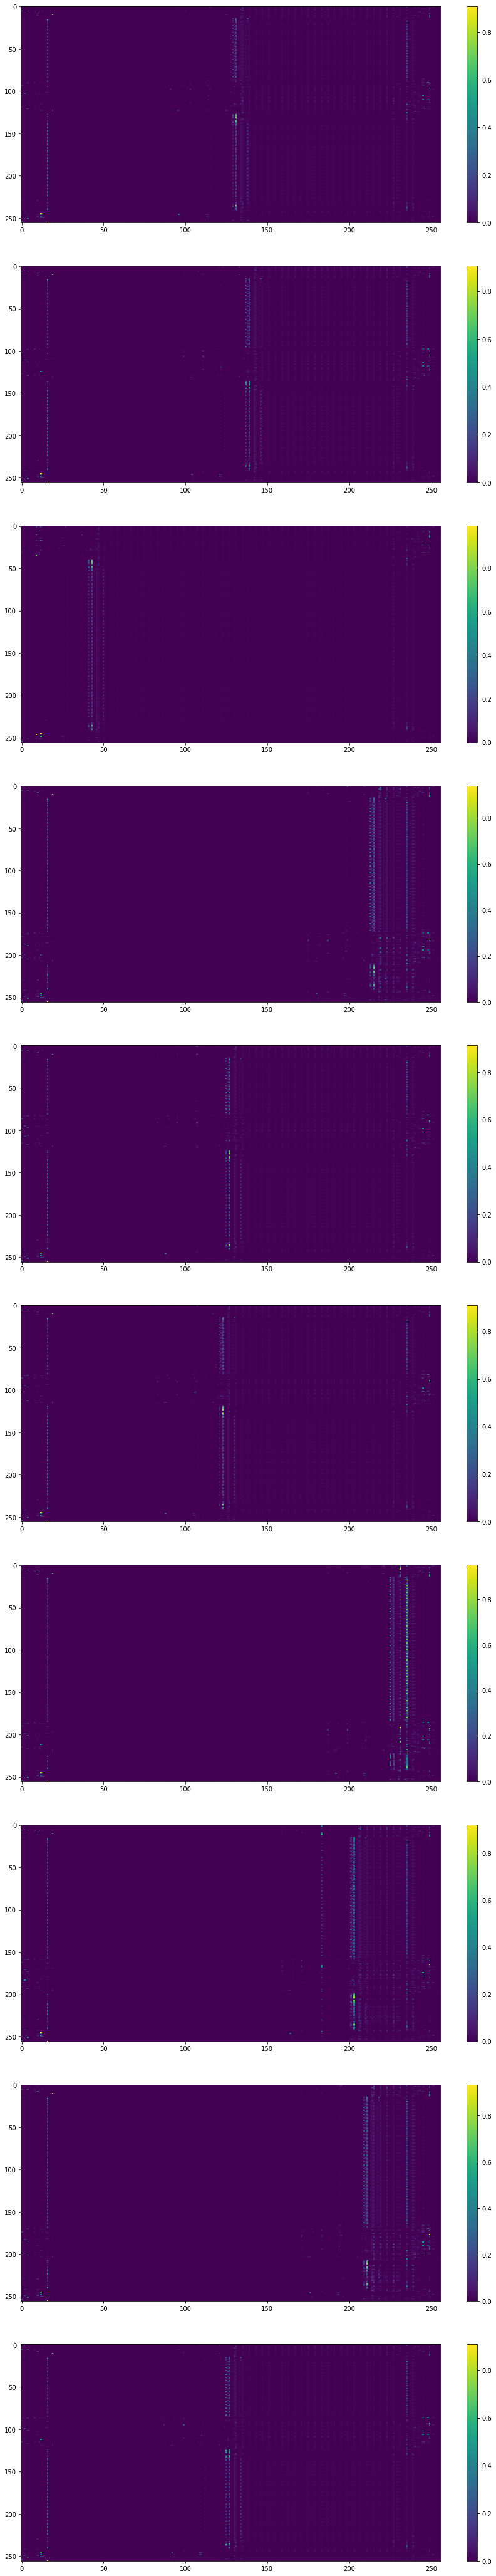

In [8]:
import matplotlib.pyplot as plt
tf.keras.layers.GlobalAveragePooling1D()

batches_m = meso_val.batch(128, drop_remainder=True)
batches_z = thermo_val.batch(128, drop_remainder=True)
for i, seq in enumerate(zip(batches_m, batches_z)):
    
    X_int, X_bin, W_x = seq[0]
    Z_int, Z_bin, W_z = seq[1]
    y_fake = cycle_gan_model.G(X_bin)
    y, a = cycle_gan_model.D_x(y_fake)

fig, axs  = plt.subplots(10,1)#sharex = True, gridspec_kw = {'height_ratios': [1,8]})
fig.set_figheight(75)
fig.set_figwidth(15)
for i in range(10):
    im =axs[i].imshow(a.numpy()[i,:,:], aspect="auto")
    axs[i].figure.colorbar(im, ax=axs[i])

    
plt.show()

In [20]:
cycle_gan_model.D_x.attention.gamma

<tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.979369>

In [9]:
d ={0: 'A',
        1: 'C',
        2: 'D',
        3: 'E',
        4: 'F',
        5: 'G',
        6: 'H',
        7: 'I',
        8: 'K',
        9: 'L',
        10: 'M',
        11: 'N',
        12: 'P',
        13: 'Q',
        14: 'R',
        15: 'S',
        16: 'T',
        17: 'V',
        18: 'W',
        19: 'Y',
        20: 'X',}

seqs_c = []
seqs_x = []
seqs_y = []
seqs_t = []
batches = meso_val.batch(128, drop_remainder=True)
for i, seq in enumerate(batches):
    
    X_int, X_bin, W_x = seq
    prediction = cycle_gan_model.G(X_bin)
    prediction_t = tf.keras.backend.argmax(prediction, axis=-1)
    prediction_c = tf.keras.backend.argmax(cycle_gan_model.F(prediction), axis=-1)
    for j in range(128):
        stop = tf.reduce_sum(W_x[j], axis=None)
        seqs_t.append((''.join([d[i] for i in prediction_t[j].numpy()[:stop]]), str(i)+'_changed'))
        seqs_x.append((''.join([d[i] for i in X_int[j].numpy()[:stop]]), str(i)+'_Meso'))
        seqs_c.append((''.join([d[i] for i in prediction_c[j].numpy()[:stop]]), str(i)+'_cyceld'))
batches = thermo_val.batch(128, drop_remainder=True)
for i, seq in enumerate(batches):
    
    X_int, X_bin, W_x = seq
    for j in range(128):       
        seqs_y.append((''.join([d[i] for i in X_int[j].numpy()[:stop]]), str(j)+'_Thermo'))


In [10]:
print(seqs_y[1])

('GAMEDPFFVVKGEVQKAVNTAQGLFQRWTELLQDPSTATREEIDWTTNELRNNLRSIEWDLEDLDETISIVEANPRKFNLDATELSIRKAFITSTRQVVRDMKDQMSTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX', '1_Thermo')


In [15]:
print(seqs_x[2])

('SLDFRSADFLRTHISDTMAFYHPRCIDSAGGFFHYFRDDGSIYNATHRHLVSSTRFVFNYAMAYLQFGTAEYLDAVHHGLSYVRDVHRNPATGGYAWTLCDDRVEDDTNHCYGLAFVMLAYSCGLKVGIKQAREWMDETWCLLERHFWDAEYGLYKDEADAQWNFTRYRGQNANMHMCEAMLAAYEASGEQRYLERALVLADRITRRQAAKADGLVWEHYDMRWEVDWDYNRDNPKHLFRPWGFQPGHQTEWAKLLLILDRYIEVEWLVPVARSLFDVAVARSWDAVRGGLCYGFAPDGTICDDDKYFWVQAESLAAAALLATRSGDERYWQWYDRLWAYAWQHMVDHRYGAWYRLLDGDNRKYNDEKSPAGKTDYHTMGACHEVLNVVWT', '0_Meso')


In [14]:
print(seqs_t[2])

('ITMTRLPMFWTIRIFMTRPPTGLPFLKRDTLRLGWXMRMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXMPMMFVRXVRMMFRRXMRMMKGKXEPLGTGWXVRMMFRTMVRMMGGTXVTMMKHWXVPMPFFKRMMM', '0_changed')


In [13]:
print(seqs_c[1])

('SSTGTQGQSCSPSPQESGSSSSISIWPSASSSSVLSTFQQSCMSTFQQSCMSSCQSSVQSSPQSSVQSSSQSSVQSSSQSSCQSSPQSSCQSSPQSSVQSSPQSSVQSSPQSSVQSSPQSSVQSSPQSSVQSSPQSSVQSSPQSSVQSSPQSSVQSSCQSSVLSAFQSSCPSAPGWSCLSTSTPSCPMLSSSHQXSLXGRKSPSSCQSPSSLSSQSSSPLQQSSSHPFLQSCGXSQLXSPSQSQSQSESQSQL', '0_cyceld')


In [ ]:
#Write FASTA

from Bio import SeqIO


name = 'seqs.ali'
with open(name, "w") as output_handle:
        for seq in seqs_c[:100]:
              output_handle.write('>' +seq[1]+'\n'+seq[0]+'\n')
        for seq in seqs_x[:100]:
              output_handle.write('>' +seq[1]+'\n'+seq[0]+'\n')
        for seq in seqs_y[:100]:
              output_handle.write('>' +seq[1]+'\n'+seq[0]+'\n')